This notebook contains the experiments for the case where model have access to initial web context. Here we try to have the models come up with novel search queries during the debate for disambiguation of their argument.

In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt
from utils.external_retrieval import get_query_answer

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

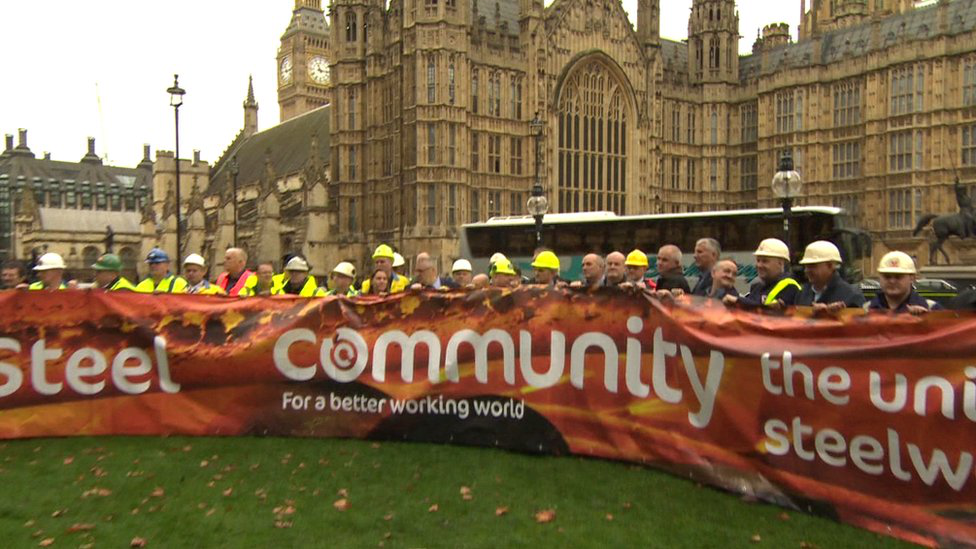

Caption:  Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members
Misinformation (Ground Truth): True


In [3]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

data_idx = 1
image, caption, img_path, data_annotation = get_data(data_idx)
display(image)
show_data(data_idx)
image_size = image.size

# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)


In [4]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()

    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../utils/summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [5]:
def round1_prompt_with_disambiguation(role, text):
    prompt = """ {}: This is what I think: {}. Do you agree with me? If you think I am wrong then convince me why you are correct.
            Clearly state your reasoning and tell me if I am missing out on some important information or am making some logical error.
            Do not describe the image. At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?

            If you think my argument has some ambiguities then generate 1 disambiguation query delimited by ```search_query``` tags, that I can use to search the web to either correct my wrong argument or strengthen my exisiting argument. 
            """.format(role, text)
    return prompt

In [6]:
def debate_prompt_with_disambiguation(role, text):
    prompt = """ {}: I see what you mean and this is what I think: {}. Do you agree with me?
                If not then point out the inconsistencies in my argument (e.g. location, time or person related logical confusion) and explain why you are correct. 
                If you disagree with me then clearly state why and what information I am overlooking.
                At the end give a definite YES or NO answer to this question: IS THIS MISINFORMATION?

                If you think my response has some ambiguities or missing information then generate 1 disambiguation query delimited by ```search_query``` tags, that I can use to search the web to either correct my wrong argument or strengthen my exisiting argument. 
            """.format(role, text)
    return prompt

In [7]:
def refine_prompt(role, query, search_result, prev_response):
    prompt = """{}: In order to refine your earlier response, I searched the web with this query: {}. 
                This is the search result I found: {}.
                Based on this result, refine your earlier response to include more details and explanations.
                Get rid of the disambiguation query if there is one demilited by ```search_query``` tags.
                Earlier response: {}.
    """.format(role, query, search_result, prev_response)
    return prompt

In [8]:
def retrieve_stored_url(key, file_path="../utils/retrieval_urls.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
    urls = data[key]
    return urls

In [9]:
def refine_response(data_idx, i, conv, models, image_tensor, temperature, image_size, max_new_tokens, role, query, prev_response):
    print("REFINING RESPONSE!! - AGENT: ", i+1)
    key = str(data_annotation['id'])+"_"+str(data_annotation['image_id'])
    matching_urls = retrieve_stored_url(key)
    print("!!!!!!!!!!! QUERY BEING PASSED: ", query)
    #print("************* PREVIOUS RESPONSE: ", prev_response)
    search_result = get_query_answer(matching_urls, query)
    print("Search result for the query: ", search_result)
    inp = refine_prompt(role, query, search_result, prev_response)
    conv[i].append_message(conv[i].roles[0], inp)
    conv[i].append_message(conv[i].roles[1], None)
    outputs = generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens)
    conv[i].messages.pop()
    conv[i].messages.pop()
    return outputs

In [10]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 3

In [11]:
search_result = ""
search_done = False
summary_key = str(data_annotation['id'])+"_"+str(data_annotation["image_id"])
context = retrieve_summary(summary_key)
print("CONTEXT: \n\n", context)
image_size = image.size
queries = {0:"", 1:""}
temp = ""
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
for round in range(num_rounds+1):
    for i in range(num_models):
        if round == 0:
            inp = initial_prompt_with_context(roles[i][0], caption, context)
        elif round == 1:
            if i == 1:
                inp = round1_prompt_with_disambiguation(roles[i][0], temp)
            else:
                inp = round1_prompt_with_disambiguation(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        else:
            inp = debate_prompt_with_disambiguation(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        if image is not None:
            # first message
            if models[i]['model'].config.mm_use_im_start_end:
                inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
            else:
                inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
            if round == 0 and i == 1:
                image = None

        conv[i].append_message(conv[i].roles[0], inp)
        conv[i].append_message(conv[i].roles[1], None)
        outputs = generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens)
        conv[i].messages[-1][-1] = outputs
        #print(outputs)
        if "```search_query" in outputs:
            queries[(i+1)%num_models] = outputs[outputs.find("```search_query")+len("```search_query"):]

        if i == 0 and round == 0:
            temp = outputs
        #final answer from the model
        if "YES" in outputs or "yes" in outputs or "Yes" in outputs:
            model_responses[i]["falsified"] = True
            model_responses[i]["output"] = outputs
        elif "NO" in outputs or "no" in outputs or "No" in outputs:
            model_responses[i]["falsified"] = False
            model_responses[i]["output"] = outputs
        else:
            model_responses[i]["falsified"] = "Unsure"
            model_responses[i]["output"] = outputs
    print(queries)
    if queries[0] != "":
        print("agent-1 query!")
        outputs = refine_response(data_idx, 0, conv, models, image_tensor, temperature, image_size, max_new_tokens, roles[0][0], queries[0], conv[0].messages[-1][-1])
        model_responses[0]['outputs'] = outputs
        #print("PREV MESSAGE: ", conv[0].messages[-1][-1])
        conv[0].messages[-1][-1] = outputs
    if queries[1] != "":
        print("agent-2 query!")
        outputs = refine_response(data_idx, 1, conv, models, image_tensor, temperature, image_size, max_new_tokens, roles[1][0], queries[1], conv[1].messages[-1][-1])
        model_responses[1]['outputs'] = outputs
        #print("PREV MESSAGE: ", conv[1].messages[-1][-1])
        conv[1].messages[-1][-1] = outputs
        
    if model_responses[0]['falsified'] == model_responses[1]['falsified'] and round != 0:
        print("******************* Models agree!! *****************")
        break

CONTEXT: 

 SUMMARY:
            
            Steelworkers in the UK are facing redundancy and have held a protest in London to raise awareness of the issue.
            The industry is blaming cheap Chinese imports and high energy costs for the collapse in steel prices.
            Labour leader Jeremy Corbyn has promised that a future Labour government would intervene to save the steel industry.
            He suggested that the government could take a joint enterprise with the company or take ownership of the industry.
            The protest was well-attended, with workers traveling from all over the UK to demonstrate their concern.
AGENT - 1: 
Based on the image provided and the summary of news articles, the caption "Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members" does not accurately describe the scene depicted.

The image shows a group of people, many of whom are wearing hard 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Both `max_new_tokens` (=1000) and `max_length`(=3000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Found 2 search results.
Search result for the query:  ANSWER:
             Based on the text delimited by triple backticks, the relationship between the steel industry and the Crossrail project in London is that the steel industry is facing job losses and the government is not intervening, while the Crossrail project is using steel from China, which is contributing to the collapse of the steel industry in the UK.
AGENT - 1: 
Based on the search result you provided, it appears that the steel industry in the UK is facing job losses due to the collapse of steel prices, which is partly attributed to the use of Chinese steel in projects like the Crossrail. The government is not intervening to save the steel industry, which is contributing to the decline of the industry.

Therefore, the image does not depict a flashmob protest at a Crossrail site. Instead, it shows a group of steel industry workers protesting in front of the Houses of Parliament in London, as indicated by the news articles. 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Both `max_new_tokens` (=1000) and `max_length`(=3000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Found 2 search results.
Search result for the query:  ANSWER:
             Based on the text delimited by triple backticks, the relationship between the steel industry and the Crossrail project in London is not explicitly mentioned. The text discusses the impact of cheap Chinese imports and high energy costs on the steel industry, and the potential for government intervention to save the industry. There is no mention of the Crossrail project in the text.
AGENT - 2: 
Based on the image and the summary of news articles, the caption "Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members" does not accurately describe the scene depicted in the image.

The image shows a group of people holding a banner that reads "Steel Community" and "For a better working world," which suggests that the protest is related to the steel industry. The individuals are wearing hard hats, indicating that they are lik

: 